Process: 
1. Create DataFrames for all PVs of interest over a 6-month timeframe: `df_pv = pd.read_csv()`
2. Remove charges less than a given value, like 15 pC: `df_charge = df_charge[df_charge[pv_charge] >= cutoff]`
3. Merge all DataFrames together, by Timestamp, given a margin of error:
```
df_charge_ycor = merge_with_margin_on_timestamp(df_charge, df_ycor, time_margin_seconds=10)
df_correl = merge_with_margin_on_timestamp(df_charge_ycor, df_homc1, time_margin_seconds=10)
```
4. Plot the correlation with error due to the spread of certain values:
```
plot_correlation(df_correl, pv_y="SCOP:AMRF:RF01:AI_MEAS1", pv_x="YCOR:GUNB:293:BACT", pv_charge="TORO:GUNB:360:CHRG", charge_val=50.0, charge_tolerance=0.5, plot_error_bars=True, low_vary_column="YCOR:GUNB:293:BACT", high_vary_column: "SCOP:AMRF:RF01:AI_MEAS1", error_tolerance=0.000015, y_vary=True)
```

Note: 
- To determine which `charge_val` to choose, one must run the method `separate_df_by_charges` from the `ChargeSeparator` class. 
- Trial and error must be done to determine what values to use for parameters `charge_tolerance` and `error_tolerance`. 

Imports

In [1]:
import charge_separator as cs
import sys
sys.path.append('/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/archiver_plotter')
import archiver_plotter as ap # type: ignore
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import ticker
import pandas as pd
import numpy as np

Goal: remove charges less than a given value for a charge DataFrame

In [2]:
def remove_charges_below_value(df: pd.DataFrame, pv_charge: str, min_charge_value: float) -> pd.DataFrame:
    return df[df[pv_charge] >= min_charge_value]

Goal: merge all DataFrames together, by Timestamp, given a margin of error

In [3]:
def merge_with_margin_on_timestamp(df_1: pd.DataFrame, df_2: pd.DataFrame, time_margin_seconds: float): 
    """Merges two DataFrames on similar timestamps, where timestamps differ by less than the time specified by the time_margin parameter.
    
    Creates additional columns that store the time difference between the true and comparison timestamps. 
    
    :param df_1: First DataFrame with a Timestamp column.
    :param df_2: Second DataFrame with a Timestamp column.
    :param time_margin_seconds: The time margin between two timestamps as given in seconds, useful for defining the propagated error for a correlation.
    """
    
    # Must convert the values in the Timestamp column to datetime objects
    df_1["Timestamp"] = pd.to_datetime(df_1["Timestamp"])
    df_2["Timestamp"] = pd.to_datetime(df_2["Timestamp"])
    
    """Use the pandas method merge_asof to merge the DataFrames within a tolerance value (pandas.pydata.org/docs/reference/api/pandas.merge_asof.html). 
    According to the pd.merge_asof() function, the first DataFrame parameter in the function defines what the second DataFrame is compared to. 
    Therefore, the first DataFrame will have a time-axis uncertainty of 0. 
    The second DataFrame will have some uncertainty ranging from 0 to the time_margin_seconds value. 
    """
    
    # compute the time difference between the second and first DataFrames and add a new column to the second DataFrame
    df_merged = pd.merge_asof(df_1, df_2, on="Timestamp", direction="nearest", tolerance=pd.Timedelta(f"{time_margin_seconds}s"))
    df_merged[f"{df_2.columns[1]} Time Uncert"] = df_merged[df_2.columns[1]] - df_merged[df_1.columns[1]]  # get time uncertainty
    
    # Convert values in the Timestamp column back to String objects, remove NaN rows, and return 
    timestamp_list = df_merged["Timestamp"].to_list()
    df_merged["Timestamp"] = timestamp_list
    return df_merged.dropna(how="any")

Goal: plot the correlation with a line of best fit, either with or without error bars

In [4]:
def create_clusters(df: pd.DataFrame, low_vary_column: str, error_tolerance: float) -> list[pd.DataFrame]: 
    """Create a list of DataFrames, each with data points with similar x values but varying y values.
    
    :param df: DataFrame with at least and x_column and a y_column from which to create clusters. 
    :param low_vary_column: String of the title of the column with points by which to create clusters.
    :param error_tolerance: The tolerance range of the x values in whatever units the x_column is. 
    """
    
    df = df.sort_values(by=low_vary_column).reset_index(drop=True)
    
    # group the values by similar x values
    df_groups: list[pd.DataFrame] = []
    curr_group: list[pd.Series] = []
    
    for i, curr_row in df.iterrows(): 
        if not curr_group: 
            curr_group.append(curr_row)  # add current row to the group if no rows added yet
        else: 
            # if the row is not empty, check if the item in the cell in the x_column of the current row in within range
            if abs(curr_group[-1][low_vary_column] - curr_row[low_vary_column]) <= error_tolerance: 
                curr_group.append(curr_row)
            else: 
                # if it is out of range, add the current group as a DataFrame to the list
                df_groups.append(pd.DataFrame(curr_group))
                curr_group = [curr_row]  # create a new group with the new row
    
    # handle remaining rows and add to a DataFrame and then to the DataFrame list
    if curr_group: 
        df_groups.append(pd.DataFrame(curr_group))
        
    return df_groups

In [5]:
def get_means_and_stds(df_groups: list[pd.DataFrame], high_vary_column: str) -> list[tuple[float, float]]:
    """Create a 2D list with means and standard deviations for each cluster.
    
    Returns a list of pairs (mean of each cluster, std for each cluster). 
    
    :param df_groups: List of DataFrames, each one representing a different cluster. 
    :param high_vary_column: String of the title of the column with the varying points in a cluster. 
    """
    
    result = []
    for group_index in range(len(df_groups)):
        mean = float(np.mean(df_groups[group_index][high_vary_column]))
        curr_std = float(np.std(df_groups[group_index][high_vary_column]))
        result.append((mean, curr_std))
    return result

In [6]:
def plot_correlation(df: pd.DataFrame, 
                     pv_y: str, 
                     pv_x: str, 
                     pv_charge: str, 
                     charge_val: float, 
                     charge_tolerance: float, 
                     plot_error_bars: bool, 
                     low_vary_column: str, 
                     error_tolerance: float, 
                     x_label: str, 
                     y_label: str, 
                     y_vary=True, 
                     x_num_rounded_digits: int = 5, 
                     y_num_rounded_digits: int = 5, 
                     x_units: str = "", 
                     y_units: str = "", 
                     x_change_decimal_point: int = 0, 
                     y_change_decimal_point: int = 0): 
    """Plots the correlation between two columns in a DataFrame, separated by a specific charge value (pC). 
    
    DataFrame will be modified to only include rows that contain a charge value within a given tolerance percentage range (0.0-1.0). 
    
    Charge-separation: 
    
    :param df: DataFrame with a Timestamp column and an arbitrary amount of PV columns.
    :param pv_y: String representation of the PV to be plotted on the y-axis.
    :param pv_x: String representation of the PV to be plotted on the x-axis.
    :param pv_charge: String representation of the charge PV by which to filter the DataFrame.
    :param charge_val: The charge value in pC by which to separate out rows. 
    :param charge_tolerance: The percentage tolerance between 0.0-1.0 (inclusive) to inform how large of a spread of charge values are kept in the DataFrame. 
    
    Error bars: 
    
    :param plot_error_bars: Boolean flag specifying whether to plot the error bars.
    :param low_vary_column: String of the title of the column with points by which to create clusters. 
    :param error_tolerance: The tolerance range of the x values in whatever units the x_column is. 
    :param y_vary: Boolean indicating if the y_column is varying or not.
    
    Axis label customization:
    
    :param x_label: String representation of the x-axis label.
    :param y_label: String representation of the y-axis label.
    
    :param x_num_rounded_digits: Optional, Number of digits to round off the x-axis values.
    :param y_num_rounded_digits: Optional, Number of digits to round off the y-axis values.
    :param x_units: Optional, String representation of the x-axis units.
    :param y_units: Optional, String representation of the y-axis units.
    :param x_change_decimal_point: Optional, positive integer raises the x-axis labels by orders of magnitude, negative decreases. 
    :param y_change_decimal_point: Optional, positive integer raises the y-axis labels by orders of magnitude, negative decreases.
    """
    
    # filter out unwanted charges
    df_charge_filtered = df[(df[pv_charge] >= charge_val - (charge_val * charge_tolerance)) & (df[pv_charge] <= charge_val + (charge_val * charge_tolerance))]
    fig, ax = plt.subplots(figsize=(10, 5))
    # plot correlation points
    x = df_charge_filtered[pv_x]
    y = df_charge_filtered[pv_y]
    
    if plot_error_bars:
        # plot cluster points
        df_groups: list[pd.DataFrame] = create_clusters(df, low_vary_column, error_tolerance)
        means_and_stds: list[(float, float)] = get_means_and_stds(df_groups, "SCOP:AMRF:RF01:AI_MEAS1")
        
        y_cluster_points = []
        x_cluster_points = []
        if y_vary:  # if the points in the y_column are the varying points in a cluster
            y_cluster_points = [cluster[0] for cluster in means_and_stds]  # average y val in each cluster
            x_cluster_points = [float(np.mean(df_groups[df][pv_x])) for df in range(len(df_groups))]  # average x val in each cluster
        else: 
            y_cluster_points = [float(np.mean(df_groups[df][pv_y])) for df in range(len(df_groups))]  # average y val in each cluster
            x_cluster_points = [cluster[0] for cluster in means_and_stds]  # average x val in each cluster
            
        ax.scatter(x_cluster_points, y_cluster_points)
        # create a line of best fit
        slope, intercept = np.polyfit(x_cluster_points, y_cluster_points, deg=1)  
        ax.axline(xy1=(0, intercept), slope=slope, label=f"y = {slope:.3f}x + {intercept:.3f}")
            
        # plot error bars
        error = [cluster[1] for cluster in means_and_stds]
        ax.errorbar(x_cluster_points, y_cluster_points, yerr=error, ls="none")
    else: 
        ax.scatter(x, y) 
        # create a line of best fit
        slope, intercept = np.polyfit(x, y, deg=1)  
        ax.axline(xy1=(0, intercept), slope=slope, label=f"y = {slope:.3f}x + {intercept:.3f}")
    
    # set labels
    start_date = str(df_charge_filtered["Timestamp"].to_list()[0])[:10]
    end_date = str(df_charge_filtered["Timestamp"].to_list()[-1])[:10]
    ax.set_title(f"{y_label} vs. {x_label} for {charge_val}pC from {start_date} to {end_date}")
    ax.set_xlabel(f"{x_label} {x_units}")
    ax.set_ylabel(f"{y_label} {y_units}")
    # set ticks
    x_digit_round_string = f"{{x:,.{x_num_rounded_digits}f}}"
    y_digit_round_string = f"{{x:,.{y_num_rounded_digits}f}}"
    ax.xaxis.set_major_formatter(StrMethodFormatter(x_digit_round_string))
    ax.yaxis.set_major_formatter(StrMethodFormatter(y_digit_round_string))
    # change values of x-axis or y-axis ticks to a different order of magnitude
    x_tick_locs = list(ax.get_xticks())
    y_tick_locs = list(ax.get_yticks())
    # raise or lower to the given power
    x_tick_labels = [round(x*(10**x_change_decimal_point), x_num_rounded_digits) for x in x_tick_locs] 
    # raise or lower to the given power
    y_tick_labels = [round(y*(10**y_change_decimal_point), y_num_rounded_digits) for y in y_tick_locs] 
    ax.xaxis.set_major_locator(ticker.FixedLocator(x_tick_locs))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_tick_labels))
    ax.yaxis.set_major_locator(ticker.FixedLocator(y_tick_locs))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_tick_labels))
    """
    positions = [0, 1, 2, 3, 4, 5]
    labels = ['A', 'B', 'C', 'D', 'E', 'F']
    axs2[4].xaxis.set_major_locator(ticker.FixedLocator(positions))
    axs2[4].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    """ 
    
    ax.legend()
    plt.show()

Example

In [7]:
df_homc1 = pd.read_csv("/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/SCOP_AMRF_RF01_AI_MEAS1_6M.csv")
df_chrg = pd.read_csv("/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/TORO_GUNB_360_CHRG_6M.csv")
df_ycor = pd.read_csv("/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/YCOR_GUNB_293_BACT_6M.csv")

In [8]:
df_chrg_filtered = remove_charges_below_value(df_chrg, "TORO:GUNB:360:CHRG", min_charge_value=15.0)

In [9]:
df_chrg_ycor = merge_with_margin_on_timestamp(df_chrg_filtered, df_ycor, time_margin_seconds=10.0)
df_correl = merge_with_margin_on_timestamp(df_chrg_ycor, df_homc1, time_margin_seconds=10.0)

/var/folders/cq/8dkx5q294xz7cqz20lrdpqj80000gn/T/ipykernel_2676/65976410.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["Timestamp"] = pd.to_datetime(df_1["Timestamp"])


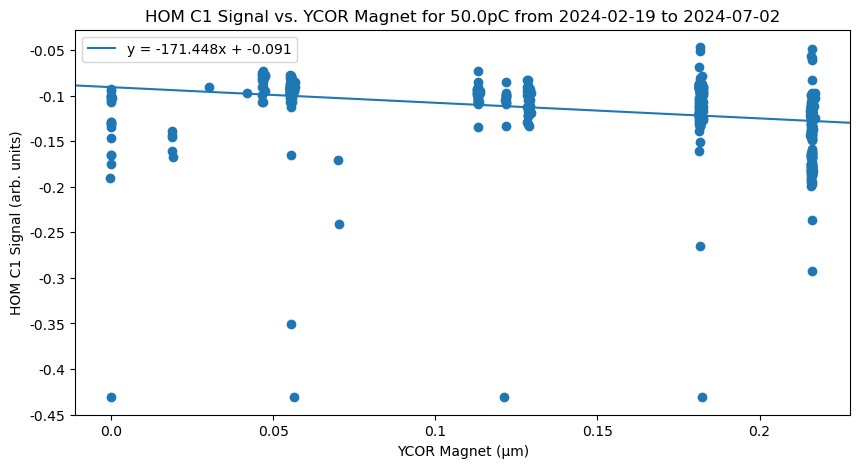

In [10]:
"""
:param x_num_rounded_digits: Optional, Number of digits to round off the x-axis values.
:param y_num_rounded_digits: Optional, Number of digits to round off the y-axis values.
:param x_units: Optional, String representation of the x-axis units.
:param y_units: Optional, String representation of the y-axis units.
:param x_change_decimal_point: Optional, positive integer raises the x-axis labels by orders of magnitude, negative decreases. 
:param y_change_decimal_point: Optional, positive integer raises the y-axis labels by orders of magnitude, negative decreases.
"""

plot_correlation(df_correl, pv_y="SCOP:AMRF:RF01:AI_MEAS1", pv_x="YCOR:GUNB:293:BACT", pv_charge="TORO:GUNB:360:CHRG", 
                 charge_val=50.0, charge_tolerance=0.5, plot_error_bars=False, low_vary_column="YCOR:GUNB:293:BACT",
                 error_tolerance=0.000015, x_label="YCOR Magnet", y_label="HOM C1 Signal", y_vary=True, x_num_rounded_digits=5, y_num_rounded_digits=2, x_units="(μm)", y_units="(arb. units)", x_change_decimal_point=3) 

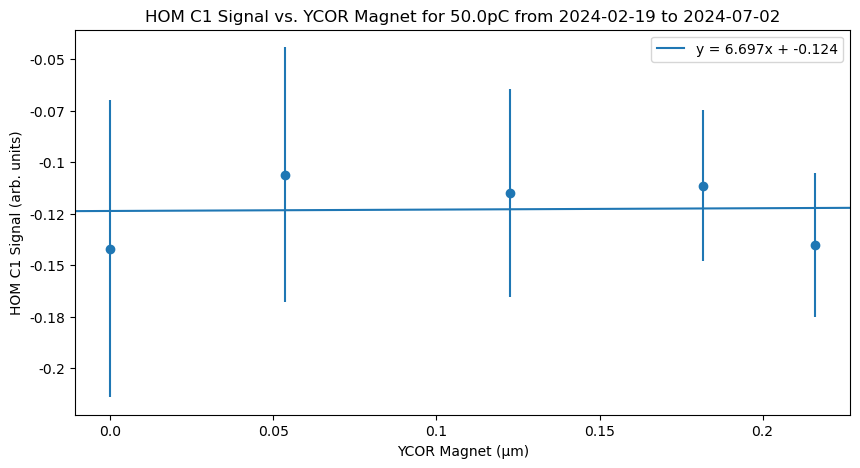

In [11]:
# TODO: plot line of best fit through the means, or all the data points? 
plot_correlation(df_correl, pv_y="SCOP:AMRF:RF01:AI_MEAS1", pv_x="YCOR:GUNB:293:BACT", pv_charge="TORO:GUNB:360:CHRG", 
                 charge_val=50.0, charge_tolerance=0.5, plot_error_bars=True, low_vary_column="YCOR:GUNB:293:BACT",
                 error_tolerance=0.000015, x_label="YCOR Magnet", y_label="HOM C1 Signal", y_vary=True, x_num_rounded_digits=5, y_num_rounded_digits=2, x_units="(μm)", y_units="(arb. units)", x_change_decimal_point=3)